In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3
%matplotlib inline

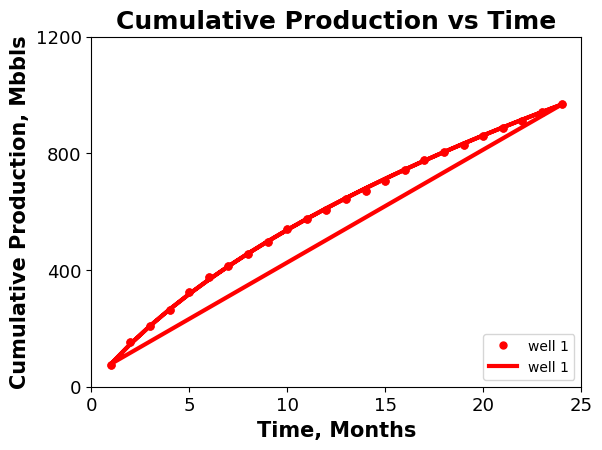

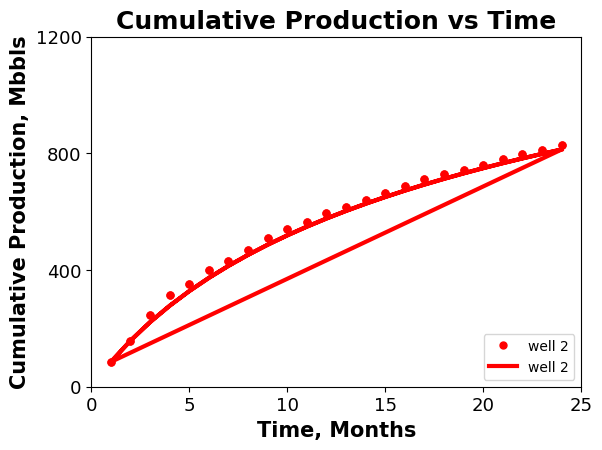

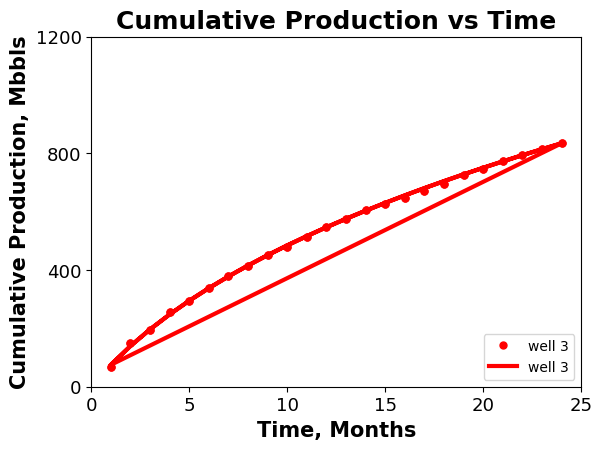

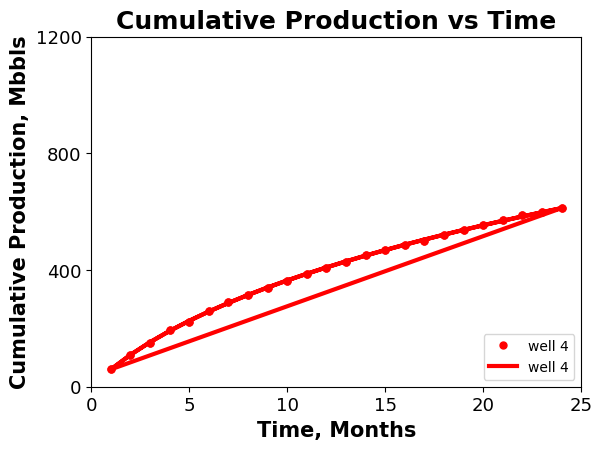

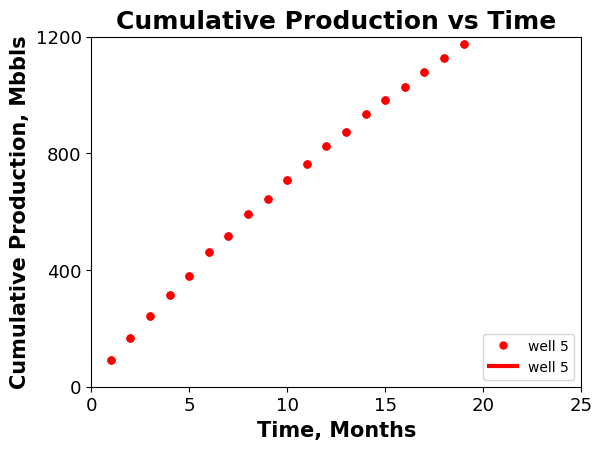

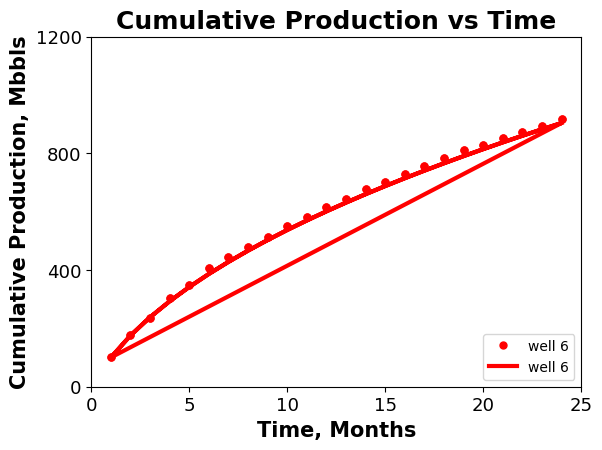

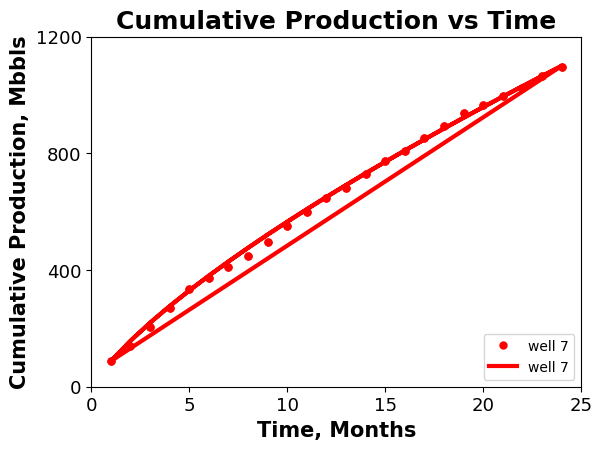

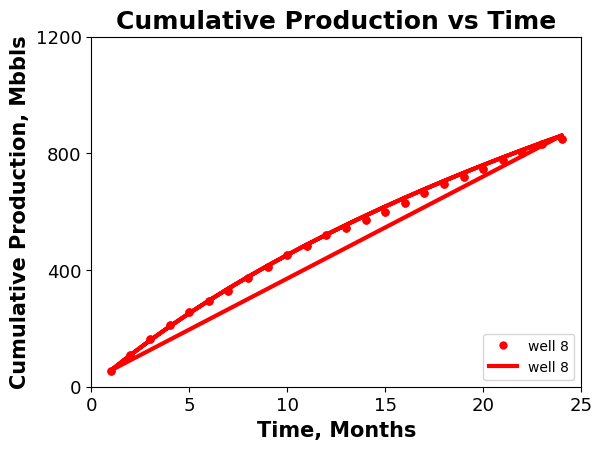

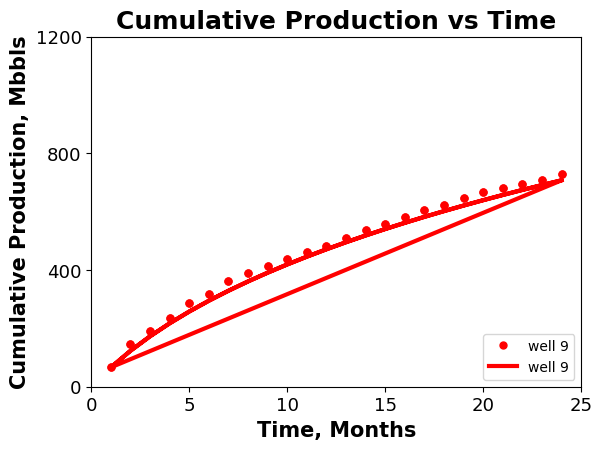

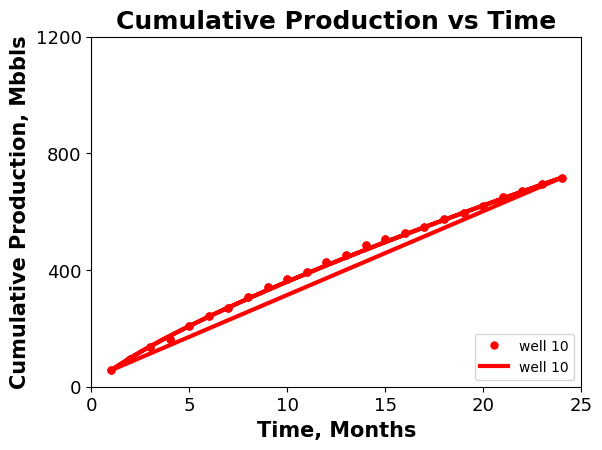

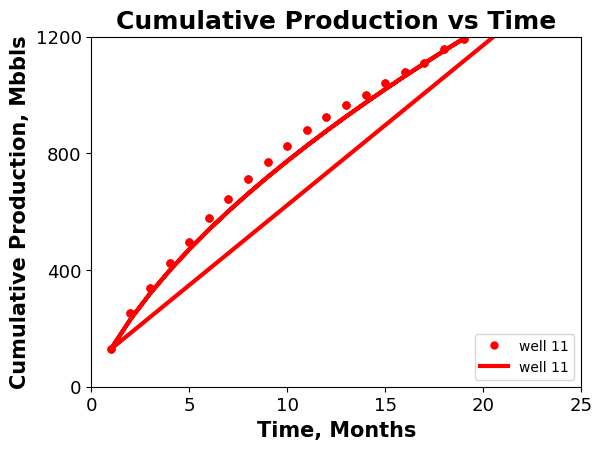

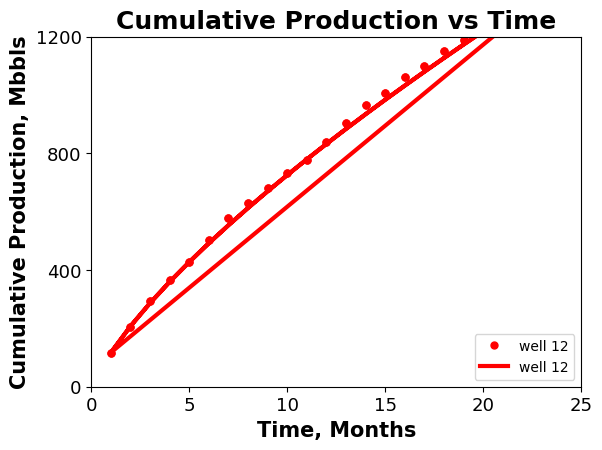

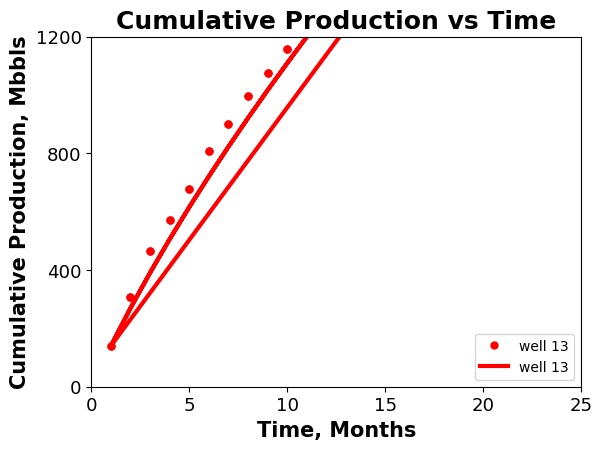

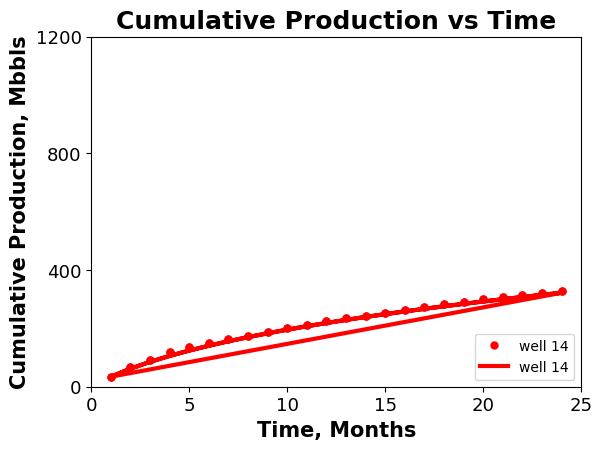

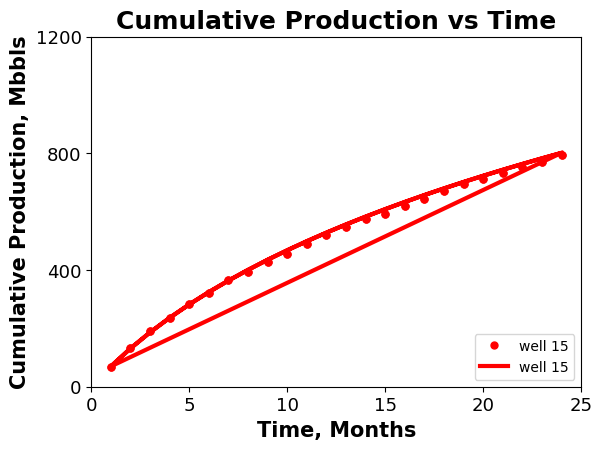

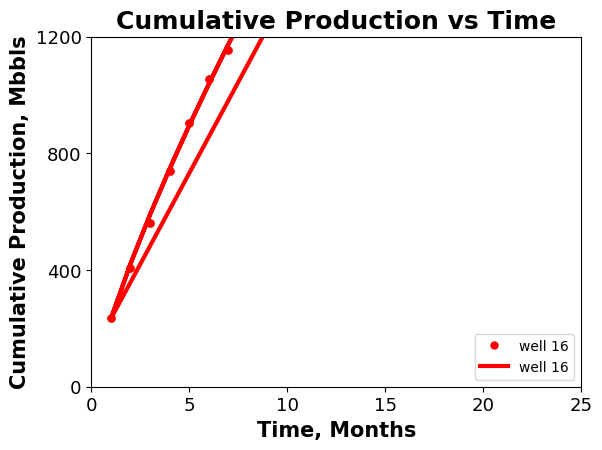

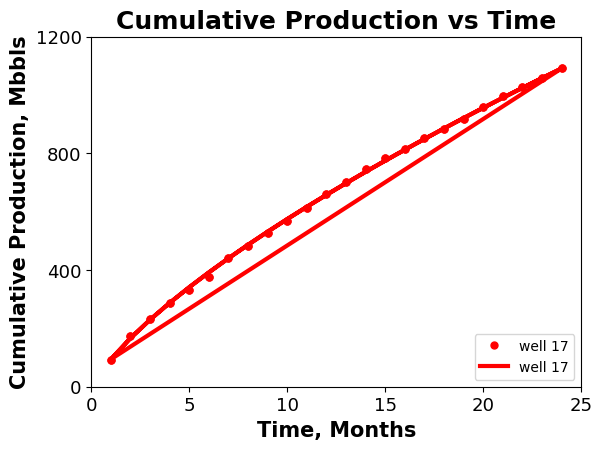

In [6]:
conn = sqlite3.connect("DCA.db")


cur = conn.cursor()

cur.execute("DROP TABLE DCAparams")
conn.commit()
cur.execute("CREATE TABLE DCAparams (wellID INTEGER,  qi REAL, Di REAL, b REAL)")
conn.commit()

dfLength = 24
for i in range(1,18):
    wellID = i
    
    xl = pd.ExcelFile('DCAwells_Solved/DCA_Well '+str(wellID)+'.xlsx')
    
    
    df1 = xl.parse('DCARegression')

    rateDF = pd.DataFrame({'wellID':wellID*np.ones(dfLength,dtype=int), 'time':range(1,dfLength+1),'rate':df1.iloc[8:32,1].values})
    rateDF['Cum'] = rateDF['rate'].cumsum()

    
    qi = df1.iloc[2,3]
    Di = df1.iloc[3,3]
    b  = df1.iloc[4,3]

    t = np.arange(1,dfLength+1)
    Di = Di/12  

    if b== 0:
        q = 30.4375*qi*np.exp(-Di*t)
        Np = 30.4375*((qi-q)/Di)
    
    else:
        q = 30.4375*qi/((1 + b*Di*t)**(1/b))
        Np = 30.4375*(qi/(Di*(1-b)))*(1-(1/(1+(b*Di*t))**((1-b)/b)))

    error_q = rateDF['rate'].values - q
    SSE_q = np.dot(error_q, error_q)

    errorNp = rateDF['Cum'].values - Np
    SSE_Np = np.dot(errorNp,errorNp)


    rateDF['q_model'] = q
    rateDF['Cum_model'] = Np
    
    rateDF.to_sql("Rates", conn, if_exists="append", index = False)

    
    df1 = pd.read_sql_query("SELECT * FROM Rates;", conn)
    df2 = pd.read_sql_query("SELECT * FROM DCAparams;", conn)
    
    conn.close()

    
    conn = sqlite3.connect("DCA.db")

    df1 = pd.read_sql_query("SELECT * FROM Rates WHERE wellID = {};".format(wellID), conn)

    
    titleFontSize = 18
    axisLabelFontSize = 15
    axisNumFontSize = 13
    
    currFig = plt.figure(figsize=(7,5), dpi=100)

    
    axes = currFig.add_axes([0.15, 0.15, 0.7, 0.7])

    
    axes.plot(df1['time'], df1['Cum']/1000, color="red", ls='None', marker='o', markersize=5,label = 'well '+str(wellID) )
    axes.plot(df1['time'], df1['Cum_model']/1000, color="red", lw=3, ls='-',label = 'well '+str(wellID) )
    axes.legend(loc=4)
    axes.set_title('Cumulative Production vs Time', fontsize=titleFontSize, fontweight='bold')
    axes.set_xlabel('Time, Months', fontsize=axisLabelFontSize, fontweight='bold') # Notice the use of set_ to begin methods
    axes.set_ylabel('Cumulative Production, Mbbls', fontsize=axisLabelFontSize, fontweight='bold')
    axes.set_ylim([0, 1200])
    axes.set_xlim([0, 25])
    xticks = range(0,30,5) 
    axes.set_xticks(xticks)
    axes.set_xticklabels(xticks, fontsize=axisNumFontSize); 

    yticks = [0, 400, 800, 1200]
    axes.set_yticks(yticks)
    axes.set_yticklabels(yticks, fontsize=axisNumFontSize); 

    currFig.savefig('well'+str(wellID)+'_Gp.png', dpi=600)
